


# Image Captioning with LSTN_Captioning and BLIP

## Introduction
This notebook explores the task of **image captioning**, where a deep learning model generates descriptive text for a given image. The project leverages **LSTN_Captioning**, a custom-built model combining **Convolutional Neural Networks (CNNs)** for feature extraction and **Long Short-Term Memory (LSTM)** networks for sequential text generation.

In addition to our custom model, we integrate and compare performance with the **BLIP (Bootstrapped Language-Image Pretraining) image captioning model**, specifically the **Salesforce/blip-image-captioning-base** model from Hugging Face. This allows us to benchmark results and analyze the differences between a pre-trained state-of-the-art model and our own implementation.

## Key Features
- **Custom LSTN_Captioning Model**:
  - Uses a **CNN backbone** for image feature extraction.
  - Employs an **LSTM-based decoder** for generating captions.
  - Trained on a dataset of labeled images and descriptions.
- **Integration with BLIP**:
  - Loads the pre-trained BLIP model from Hugging Face.
  - Generates captions using BLIP's state-of-the-art transformer-based architecture.
- **Comparison & Analysis**:
  - Evaluates captions generated by both models.
  - Uses qualitative and quantitative methods for comparison.
  - Provides insights into the strengths and weaknesses of each approach.

## Dependencies
This notebook requires the following Python libraries:
- `torch`, `torchvision`: For deep learning model implementation.
- `transformers`: To load the pre-trained BLIP model.
- `numpy`, `matplotlib`: For data processing and visualization.
- `PIL`: For image handling and preprocessing.

## How to Use
## Data Preparation
**Please note that the `.rar` files in this folder are parts of a single large split archive.**

To use the data:

1. **Download all the `.rar` files.**
2. **Extract them together using a tool like [WinRAR](https://www.win-rar.com/), [7-Zip](https://www.7-zip.org/), or any other extraction software.**
3. **This will combine the split files into the original data folder.**


4. Ensure all required dependencies are installed.
5. Run the notebook cells to:
   - Load the pre-trained BLIP model.
   - Initialize and train the custom **LSTN_Captioning** model.
   - Generate captions using both models.
   - Compare the results and analyze performance.

## Expected Results
By the end of this notebook, we expect to:
- Understand how CNN-LSTM models function for image captioning.
- See how well a state-of-the-art pre-trained model like BLIP performs.
- Evaluate the accuracy and relevance of generated captions.
- Gain insights into potential improvements for custom-built captioning models.

---
This notebook serves as both an **implementation guide** and a **performance comparison** between traditional CNN-LSTM architectures and modern transformer-based approaches in image captioning.





In [2]:
import os
import sys
import copy
import zipfile
import rarfile
import time
import random
import collections
import numpy as np
from PIL import Image
import pickle
import requests

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms 

import torchvision
import torchvision.transforms as T
import torchvision.models as models

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.patches as patches

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

print(torch.__version__)
device = (
    'cuda' if torch.cuda.is_available()
    else 'mps' if torch.backends.mps.is_available()
    else 'cpu'
)
print(device)

%load_ext autoreload
%autoreload 2

2.5.1
mps


# Building Image Captioning in PyTorch 

The goal of image captioning is to describe a given image using natural language. Using neural networks, we can partition the problem into two separate challenges. First, we need to extract meaningful features regarding the image that would help us describe it. Second, we need to generate a sequence of words that best fit those features. Luckily, the flexability of neural networks allows us to take a CNN architecture and connect it directly to a LSTM network. We only need to provide proper labels to train the new network we created. For this exercise, you will be provided with pretrained networks for both feature extraction and sentence generation, and you will connect the different components needed to make image captioning work.

First, we define the feature extractor and the recurrent model seperately. The feature extractor takes an image and produces a vector representation of the image features. As those features hold information about the image, we will use that vector as the input for our recurrent model. The RNN will produce the image captioning using an LSTM architecture. 

In [3]:
# unzipping the pretrained models
# with zipfile.ZipFile(os.path.join('models', 'pretrained_model.zip'), 'r') as zip_ref:
#     zip_ref.extractall('models')
import rarfile
import os

# Define paths
rar_parts = [f'models/models.part0{i}.rar' for i in range(1, 10)]  # Adjust range as needed
output_dir = 'models'

# Check if all parts exist
missing_parts = [part for part in rar_parts if not os.path.exists(part)]
if missing_parts:
    print(f"Error: Missing parts: {', '.join(missing_parts)}")
else:
    try:
        # Open the first part and extract all files
        with rarfile.RarFile(rar_parts[0], 'r') as rf:
            rf.extractall(output_dir)
            print(f"Extracted all files to '{output_dir}' successfully.")
    except rarfile.Error as e:
        print(f"An error occurred while extracting the RAR files: {e}")

Error: Missing parts: models/models.part01.rar, models/models.part02.rar, models/models.part03.rar, models/models.part04.rar, models/models.part05.rar, models/models.part06.rar, models/models.part07.rar, models/models.part08.rar, models/models.part09.rar


In [4]:
# unzipping vocabulary
with zipfile.ZipFile(os.path.join('data', 'vocab.zip'), 'r') as zip_ref:
    zip_ref.extractall('data')
# unzipping the pretrained models
    


In [5]:
conv_path = 'models/encoder-5-3000.pkl'
lstm_path = 'models/decoder-5-3000.pkl'
vocab_path   = 'data/vocab.pkl'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Use the following code to check if all the files are in place
#print("conv_path ", '✓' if os.path.isfile(conv_path) == True else '✗') 
#print("lstm_path ", '✓' if os.path.isfile(lstm_path) == True else '✗') 
#print("vocab_path ", '✓' if os.path.isfile(vocab_path) == True else '✗') 

## Implementing image captioning model 

As training a multimodal classifier could take some time and resources, we spared you the training phase this time. In this exercise, we use a pretrained model to solve the image captioning task. Using pretrained models is a common practice in the deep learning community and it's important to be aware of such techniques to save time and energy. In previous cells, we unzipped the necessary files, but in order to be able to load the models (and then use them) it is required to build the same PyTorch model as the pretrained model.

**ConvNet architecture:** resnet152 (without last fc layer) -> fc layer -> BatchNorm1d

**LSTM architecture:** LSTM -> linear -> embed

We added more detailed instructions in the next cells, please make sure you follow them carefully. 

**Please make sure you construct your models based on the sizes we provided.**

In [6]:
embed_size   = 256      # dimension of word embedding vectors
hidden_size  = 512      # dimension of lstm hidden states
num_layers   = 1        # number of layers in lstm

In [7]:
class ConvNet(nn.Module):
    def __init__(self, embed_size):
        super(ConvNet, self).__init__()
        resnet = models.resnet152() # construct an nn.Sequential model without the last resnet152 layer
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        # make sure you define each of the None parameters
        self.linear = None
        self.bn = None
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        # Freeze the weights of the resnet
        for param in self.resnet.parameters():
            param.requires_grad = False

         #Replace the top fully connected layer
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)

        # Add a new fully connected layer that outputs a vector with the size of the wanted embedding
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
       
    
    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.linear(features)
        features = self.bn(features)
        return features


class LSTM(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        super(LSTM, self).__init__()
        self.max_seg_length = max_seq_length
        self.embed = None
        self.lstm = None
        self.linear = None
        self.embed = nn.Embedding(vocab_size, embed_size)

        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)

        self.linear = nn.Linear(hidden_size, vocab_size)
        
          
    
    def sample(self, features, states=None):
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)
            outputs = self.linear(hiddens.squeeze(1))
            predicted = outputs.max(1)[1]
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)
            inputs = inputs.unsqueeze(1)

        sampled_ids = torch.stack(sampled_ids, 1)  # (batch_size, max_seq_length)

        return sampled_ids

In [8]:
from PIL import Image

def load_image(image_path, transform=None):
    # Open the image and convert it to RGB to ensure three channels.
    image = Image.open(image_path).convert("RGB")
    # Resize the image to 224x224 using LANCZOS resampling.
    image = image.resize((224, 224), Image.Resampling.LANCZOS)
    
    if transform is not None:
        # Apply the transform. Ensure that your transform returns a tensor with shape [C, H, W]
        # Typically, this will be [3, 224, 224] for an RGB image.
        image = transform(image)
        # If your transform doesn't add a batch dimension, you can add one:
        image = image.unsqueeze(0)
    
    return image


class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [9]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))])

In [10]:
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)

In [11]:
# Build models
conv = ConvNet(embed_size).eval()  # eval mode (batchnorm uses moving mean/variance)
lstm = LSTM(embed_size, hidden_size, len(vocab), num_layers)
conv = conv.to(device)
lstm = lstm.to(device)

# Load the trained model parameters
conv.load_state_dict(torch.load(conv_path))
lstm.load_state_dict(torch.load(lstm_path))

# Prepare an image
# image_path = os.path.join('data', 'pic.jpg')

# image = load_image(image_path, transform)
# image_tensor = image.to(device)

/var/folders/x6/151sb8v51rdf6whqq8lnypsr0000gn/T/ipykernel_11863/1328127685.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  conv.load_state_dict(torch.load(conv_path))
/

<All keys matched successfully>

# Image Captioning Pipeline Functions

This section explains the key functions used in the image captioning pipeline. The pipeline is designed to process images through two different models (a custom LSTM-based model and a BLIP-based model), generate captions for each image, and display the results. Each function's role is described below.

---

## 1. `load_and_preprocess_first_model(image_path, transform, device)`

**Purpose:**  
Load an image from the given path, apply preprocessing transformations (e.g., resizing, normalization), and move the resulting tensor to the specified device (CPU or GPU).

**Details:**  
- **Input:**  
  - `image_path`: Path to the image file.  
  - `transform`: A set of preprocessing transformations (defined elsewhere) to be applied to the image.  
  - `device`: The target device where the image tensor will be loaded (e.g., `torch.device("cuda")` or `torch.device("cpu")`).

- **Process:**  
  - Calls a helper function `load_image(image_path, transform)` to load and transform the image.
  - Moves the processed image tensor to the specified device.

- **Output:**  
  - A preprocessed image tensor ready for the first model.

---

## 2. `generate_caption_first_model(image_tensor, conv, lstm, vocab)`

**Purpose:**  
Generate a caption for an image using the first (LSTM-based) captioning model.

**Details:**  
- **Input:**  
  - `image_tensor`: The preprocessed image tensor produced by the first model's preprocessing function.
  - `conv`: A convolutional network that extracts features from the image.
  - `lstm`: An LSTM network that generates the caption based on the image features.
  - `vocab`: A vocabulary mapping (e.g., a dictionary) that translates word IDs into words.

- **Process:**  
  - Passes the image tensor through the convolutional network to extract features.
  - Uses the LSTM’s sampling method to generate a sequence of word IDs.
  - Iterates over the sampled word IDs, converts each ID to its corresponding word using `vocab.idx2word`, and appends it to the caption.
  - Stops the caption generation once the `<end>` token is encountered.

- **Output:**  
  - A string representing the generated caption.

---

## 3. `load_and_preprocess_second_model(image_path)`

**Purpose:**  
Load and preprocess an image for the second (BLIP-based) captioning model.

**Details:**  
- **Input:**  
  - `image_path`: Path to the image file.

- **Process:**  
  - Opens the image using PIL and converts it to RGB (to ensure consistent color channels).
  - Uses the BLIP processor (assumed to be defined globally as `processor`) to preprocess the image and convert it into the format required by the BLIP model.

- **Output:**  
  - A tuple containing:
    1. The processed inputs (in tensor format) for the BLIP model.
    2. The original PIL image (useful for display purposes).

---

## 4. `generate_caption_second_model(inputs)`

**Purpose:**  
Generate a caption for an image using the second (BLIP-based) captioning model.

**Details:**  
- **Input:**  
  - `inputs`: Preprocessed inputs for the BLIP model, as returned by `load_and_preprocess_second_model`.

- **Process:**  
  - Uses a `torch.no_grad()` context to disable gradient computation for faster inference.
  - Generates output tokens from the BLIP model.
  - Decodes the output tokens into a string using the BLIP processor's tokenizer, while skipping any special tokens.

- **Output:**  
  - A string representing the generated caption.

---

## 5. `display_image_with_captions(image, caption_first_model, caption_second_model)`

**Purpose:**  
Display an image along with the captions generated by both models.

**Details:**  
- **Input:**  
  - `image`: The PIL image to be displayed.
  - `caption_first_model`: The caption generated by the first model.
  - `caption_second_model`: The caption generated by the second model.

- **Process:**  
  - Uses Matplotlib to create a figure and display the image.
  - Hides the axis for a cleaner presentation.
  - Sets the title of the plot to display both captions, formatted to distinguish between the two models.

- **Output:**  
  - A displayed figure showing the image and its corresponding captions.

---

## 6. `process_images(image_dir, max_images, transform, device, conv, lstm, vocab)`

**Purpose:**  
Iterate over a directory of images, generate captions for each image using both models, and display the results.

**Details:**  
- **Input:**  
  - `image_dir`: The directory containing image files.
  - `max_images`: The maximum number of images to process.
  - `transform`: Preprocessing transformations for the first model.
  - `device`: The device (CPU or GPU) on which to perform computations.
  - `conv`, `lstm`, `vocab`: Components of the first (LSTM-based) captioning model.

- **Process:**  
  - Retrieves all image files (with extensions `.png`, `.jpg`, `.jpeg`) from the specified directory.
  - Iterates over the image files, stopping after processing `max_images`.
  - For each image:
    1. Loads and preprocesses the image for the first model and generates its caption.
    2. Loads and preprocesses the image for the second model and generates its caption.
    3. Displays the image along with both generated captions using the `display_image_with_captions` function.
  
- **Output:**  
  - The function does not return any value; its purpose is to process and display the results for each image.

---

This pipeline enables side-by-side comparison of captions generated by two different models, facilitating qualitative evaluation of caption quality.


In [12]:
def load_and_preprocess_first_model(image_path, transform, device):
    """Load and preprocess image for the first model."""
    image = load_image(image_path, transform)
    return image.to(device)

def generate_caption_first_model(image_tensor, conv, lstm, vocab):
    """Generate caption using the first model."""
    feature = conv(image_tensor)
    sampled_ids = lstm.sample(feature)[0].cpu().numpy()
    
    sampled_caption = []
    for word_id in sampled_ids:
        word = vocab.idx2word[word_id]
        sampled_caption.append(word)
        if word == '<end>':
            break
    
    return ' '.join(sampled_caption)

def load_and_preprocess_second_model(image_path):
    """Load and preprocess image for the second model."""
    image = Image.open(image_path).convert("RGB")
    return processor(images=image, return_tensors="pt"), image

def generate_caption_second_model(inputs):
    """Generate caption using the second model."""
    with torch.no_grad():
        outputs = model.generate(**inputs)
    return processor.tokenizer.decode(outputs[0], skip_special_tokens=True)

def display_image_with_captions(image, caption_first_model, caption_second_model):
    """Display image with generated captions from both models."""
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis("off")  # Hide axis
    plt.title(f"First Model: {caption_first_model}\nSecond Model: {caption_second_model}", fontsize=12, fontweight="bold", color="blue")
    plt.show()

import os
import random
import matplotlib.pyplot as plt

def process_images(image_dir, max_images, transform, device, conv, lstm, vocab, show_images=True):
    """
    Process images and generate captions using both models.
    
    Parameters:
    - image_dir (str): Directory containing the images.
    - max_images (int): Maximum number of images to process.
    - transform: Preprocessing transforms for the first model.
    - device: The torch device (e.g., torch.device("cuda") or torch.device("cpu")).
    - conv: Convolutional network for feature extraction (first model).
    - lstm: LSTM model for caption generation (first model).
    - vocab: Vocabulary mapping to convert word IDs to words.
    - show_images (bool): If True, display the image with generated captions;
                          if False, no images are shown.
    """
    # List all image files (supports .png, .jpg, .jpeg)
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    # Shuffle the list so the images are processed in random order
    random.shuffle(image_files)
    
    processed_count = 0
    
    for image_file in image_files:
        if processed_count >= max_images:
            break  # Stop processing after max_images
        
        image_path = os.path.join(image_dir, image_file)
        
        # First model: generate caption using the LSTM-based model.
        image_tensor = load_and_preprocess_first_model(image_path, transform, device)
        caption_first_model = generate_caption_first_model(image_tensor, conv, lstm, vocab)
        
        # Second model: generate caption using the BLIP-based model.
        inputs, image = load_and_preprocess_second_model(image_path)
        caption_second_model = generate_caption_second_model(inputs)
        
        # Optionally display the image with the generated captions.
        if show_images:
            display_image_with_captions(image, caption_first_model, caption_second_model)
        
        processed_count += 1


# Evaluation Metrics for Image Captioning Models

This script evaluates two image captioning models using three key comparison metrics: **ROUGE**, **METEOR**, and **Cosine Similarity**. Below is a detailed explanation of each metric and its significance.

## 1. ROUGE Score (Recall-Oriented Understudy for Gisting Evaluation)
**Function: compute_metrics()**

ROUGE is a common metric for evaluating text generation tasks, comparing how well a predicted text aligns with a reference text. It is particularly used in summarization and machine translation.

- The script uses **ROUGE-L**, which considers **Longest Common Subsequence (LCS)**.
- The rougeL_fmeasure is extracted, balancing **precision, recall, and F1-score**.
- The computation compares the **first reference caption** against the generated caption.

**Formula for ROUGE-L F1-Score**:
\[
\text{ROUGE-L} = \frac{(1 + \beta^2) \times \text{Precision} \times \text{Recall}}{\beta^2 \times \text{Precision} + \text{Recall}}
\]
where:
- Precision = \( $\frac{\text{LCS length}}{\text{Predicted caption length}} $\)
- Recall = \( \frac{\text{LCS length}}{\text{Reference caption length}} \)

**Use Case:**  
ROUGE is useful for measuring how much of the reference caption is captured in the generated caption.

---

## 2. METEOR Score (Metric for Evaluation of Translation with Explicit ORdering)
**Function: compute_metrics()**

METEOR is another text similarity metric used in machine translation and text generation. Unlike ROUGE, it considers **semantic similarity, stemming, synonym matching, and word order**.

- The METEOR score is computed using the **NLTK library**.
- It works by comparing words in the predicted caption to **all reference captions**.
- **Higher METEOR scores** indicate better alignment with human-written captions.

**Formula for METEOR Score**:
\[
\text{METEOR} = F_{\text{mean}} \times (1 - \text{Penalty})
\]
where:
- \( $F_{\text{mean}} $\) is a harmonic mean of precision and recall.
- \( $\text{Penalty} $\) accounts for incorrect word ordering.

**Use Case:**  
METEOR provides a better sense of **semantic correctness** compared to ROUGE.

---

## 3. Cosine Similarity
**Function: compute_cosine_similarity()**

Cosine similarity is a numerical measure of how similar two text documents (captions) are, based on their vectorized representations.

- The script uses **TF-IDF (Term Frequency-Inverse Document Frequency)** to convert captions into numerical vectors.
- The **cosine similarity** between the predicted caption and each reference caption is computed.
- The final score is the **mean similarity** across all reference captions.

**Formula for Cosine Similarity**:
\[$
\cos(\theta) = \frac{A \cdot B}{||A|| ||B||}
$\]
where:
- \( A \) and \( B \) are TF-IDF vectors of the predicted and reference captions.
- The **dot product** of these vectors measures how much they align.
- The **magnitude (norm)** of each vector normalizes the value.

**Use Case:**  
Cosine similarity is useful for checking **textual similarity**, even when phrasing is different.

---
## 4. CLIP Loss
**Function: `compute_clip_loss()`**

CLIP Loss leverages the multi-modal understanding learned by the **CLIP (Contrastive Language–Image Pretraining)** model to measure the semantic alignment between an image and its generated caption. Unlike traditional text-based metrics, CLIP Loss directly compares the visual content of the image with the textual content of the caption within a shared embedding space.

### How It Works

1. **Multi-Modal Embeddings:**  
   - The CLIP model processes both the image and the caption to produce embeddings.  
   - These embeddings capture high-level semantic features, representing the image and text in a common latent space.

2. **Cosine Similarity:**  
   - The embeddings are normalized (converted to unit vectors) to ensure fair comparison.
   - Cosine similarity is computed between the image and text embeddings:
     \[$
     \cos(\theta) = \frac{A \cdot B}{\|A\| \|B\|}
     $\]
     where \(A\) is the image embedding and \(B\) is the text embedding.

3. **Loss Calculation:**  
   - The similarity score is then converted into a loss by subtracting it from 1:
     \[$
     \text{CLIP Loss} = 1 - \cos(\theta)
     $\]
   - A lower CLIP Loss indicates a better semantic alignment between the image and the generated caption.

### Significance

- **Semantic Alignment:**  
  CLIP Loss goes beyond surface-level word matching by evaluating the semantic content of the image and caption. This helps ensure that the generated caption truly reflects the image's content.

- **Auxiliary Training Signal:**  
  When used as an auxiliary loss during training, it can guide the model to generate captions that are not only linguistically correct but also visually relevant.

- **Robustness:**  
  Since the CLIP model is trained on a vast and diverse dataset, its embeddings are robust, making CLIP Loss a powerful tool to capture subtle semantic similarities.

### Use Case

CLIP Loss is particularly valuable in scenarios where you want to:
- **Improve Caption Quality:** Ensure that captions are more closely aligned with the image content.
- **Complement Other Metrics:** Use it alongside ROUGE, METEOR, and Cosine Similarity to obtain a holistic evaluation of caption quality.
- **Enhance Training:** Incorporate it as an additional loss term to enforce semantic consistency between the image and the caption during model training.

### Summary of CLIP Loss

| Metric       | Strengths                                                     | Weaknesses                                             |
|--------------|---------------------------------------------------------------|--------------------------------------------------------|
| **CLIP Loss**| - Captures semantic alignment between image and text.         | - Adds computational overhead due to extra model passes. |
|              | - Utilizes robust, pre-trained multi-modal embeddings.         | - Its effectiveness depends on the generalization of the pre-trained CLIP model. |
|              | - Provides an auxiliary signal to improve caption relevance.   |                                                        |

---

## 5. BLEU Score (Bilingual Evaluation Understudy)

**Function: compute_bleu()**

BLEU is a widely used metric originally developed for evaluating machine translation quality. It measures how well a generated caption matches one or more reference captions by calculating the precision of overlapping n-grams.

### Key Points

- **N-gram Precision:**  
  BLEU evaluates the percentage of n-grams (e.g., unigrams, bigrams, trigrams, and four-grams) in the generated caption that also appear in the reference captions. Typically, BLEU-1 to BLEU-4 are computed to capture different levels of granularity.

- **Brevity Penalty:**  
  To prevent very short captions from receiving artificially high scores, BLEU applies a brevity penalty. This penalty reduces the score if the generated caption is shorter than the reference captions.

### Formula for BLEU Score

The BLEU score is computed as:

\[$
\text{BLEU} = BP \times \exp\left(\sum_{n=1}^{N} w_n \log p_n \right)
$\]

where:
- \( p_n \) is the precision for n-grams of size \( n \).
- \( w_n \) are the weights (often set uniformly, e.g., \( \frac{1}{N} \) for each \( n \)).
- \( BP \) is the brevity penalty, defined as:

\[$
BP =
\begin{cases}
1 & \text{if } c > r \\
e^{(1 - \frac{r}{c})} & \text{if } c \le r
\end{cases}
$\]

with \( c \) being the length of the generated caption and \( r \) the effective reference length.

### Use Case

- **Evaluation of Caption Quality:**  
  BLEU quantifies how closely the generated captions match the reference captions in terms of exact word and phrase overlap. A higher BLEU score indicates a closer match and, presumably, better caption quality.

- **Complementary Metric:**  
  While BLEU is useful for measuring exact matches, it should be combined with other metrics like ROUGE, METEOR, Cosine Similarity, and CLIP Loss to provide a comprehensive evaluation of both surface-level and semantic quality.

### Strengths and Weaknesses

| **Strengths**                                         | **Weaknesses**                                                  |
|-------------------------------------------------------|-----------------------------------------------------------------|
| Provides a clear, quantifiable measure of n-gram overlap | May not capture semantic meaning or context effectively         |
| Widely adopted in machine translation and captioning   | Sensitive to slight variations in word order                     |
| Evaluates performance across different n-gram sizes    | Sometimes does not correlate well with human judgment of quality  |

---

**Summary:**  
BLEU offers an additional perspective on caption evaluation by focusing on exact n-gram overlaps between generated and reference captions. Although it is useful for benchmarking, it is best utilized alongside other metrics to obtain a well-rounded assessment of caption quality.



## Summary of Metrics
| Metric                | Strengths                                                                 | Weaknesses                                                              |
|-----------------------|---------------------------------------------------------------------------|-------------------------------------------------------------------------|
| **ROUGE-L**           | Captures overlapping word sequences                                       | Doesn't account for meaning variations                                |
| **METEOR**            | Uses synonym matching & word order                                        | Computationally heavier than ROUGE                                    |
| **Cosine Similarity** | Measures vector-based similarity of texts                                 | Doesn't consider linguistic meaning directly                          |
| **CLIP Loss**         | Leverages multi-modal embeddings to capture deep semantic alignment between images and captions; provides an auxiliary training signal | Adds computational overhead due to extra model passes; effectiveness depends on the generalization of the pre-trained CLIP model |
| **BLEU**              | Provides a quantifiable measure of n-gram overlap; widely adopted in MT and captioning tasks; evaluates performance across various n-gram sizes | May not capture semantic meaning; sensitive to exact word matches and phrasing variations; can penalize creative rephrasings |


Each of these metrics provides a different perspective on how well the generated captions align with human-written references.



In [13]:
import os
import json
import random
import torch
import torch.nn.functional as F
import nltk
import pandas as pd
from nltk.translate.meteor_score import meteor_score
from torchmetrics.text.rouge import ROUGEScore
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction


# Compute the BLEU score (BLEU-4 as an example)
def compute_bleu(predicted_caption, reference_captions):
    predicted_tokens = predicted_caption.split()
    reference_tokens = [ref.split() for ref in reference_captions]
    smoothing = SmoothingFunction().method1
    bleu_score = sentence_bleu(reference_tokens, predicted_tokens, smoothing_function=smoothing)
    return bleu_score

# Load COCO annotations from a JSON file
def load_coco_annotations(coco_annotations_path):
    with open(coco_annotations_path, "r") as f:
        coco_data = json.load(f)
    
    annotations = {}
    for ann in coco_data["annotations"]:
        image_id = ann["image_id"]
        caption = ann["caption"]
        if image_id not in annotations:
            annotations[image_id] = []
        annotations[image_id].append(caption)
    
    return annotations

# Compute ROUGE and METEOR scores
def compute_metrics(predicted_caption, reference_captions):
    rouge = ROUGEScore()
    # Compute ROUGE score (compared to the first reference caption)
    rouge_scores = rouge(predicted_caption, reference_captions[0])
    
    # Compute METEOR score - requires a list of words
    predicted_tokens = predicted_caption.split()
    reference_tokens = [ref.split() for ref in reference_captions]
    meteor_score_value = meteor_score(reference_tokens, predicted_tokens)
    
    return rouge_scores["rougeL_fmeasure"].item(), meteor_score_value

# Compute Cosine Similarity
def compute_cosine_similarity(predicted_caption, reference_captions):
    vectorizer = TfidfVectorizer()
    texts = [predicted_caption] + reference_captions
    tfidf_matrix = vectorizer.fit_transform(texts)
    similarities = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:]).flatten()
    return similarities.mean()  # Return the average similarity score

# Compute CLIP Loss
def compute_clip_loss(image, caption, clip_processor, clip_model, device):
    """
    Compute a CLIP loss between the given image and caption.
    The loss is defined as 1 minus the cosine similarity between the image
    and text embeddings, so a lower value indicates better alignment.
    """
    inputs = clip_processor(text=[caption], images=image, return_tensors="pt", padding=True).to(device)
    outputs = clip_model(**inputs)
    image_features = outputs.image_embeds  # [batch_size, embed_dim]
    text_features = outputs.text_embeds    # [batch_size, embed_dim]
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    loss = 1 - F.cosine_similarity(image_features, text_features).mean()
    return loss.item()

# Updated evaluate_models with an optional display flag
def evaluate_models(image_dir, max_images, transform, device, conv, lstm, vocab, coco_annotations_path, 
                    clip_processor=None, clip_model=None, show_images=False):
    """
    Evaluate both models on images from the given directory and compare their outputs to the reference captions.
    Optionally computes a CLIP loss for each generated caption if clip_processor and clip_model are provided.
    Additionally, if show_images is True, displays each image with the generated captions.
    The images are loaded in a random order every time this function is called.
    """
    # Load COCO annotations
    coco_annotations = load_coco_annotations(coco_annotations_path)
    
    # List all image files and shuffle them for random order
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith((".png", ".jpg", ".jpeg"))]
    random.shuffle(image_files)
    
    processed_count = 0
    results = []
    
    for image_file in image_files:
        if processed_count >= max_images:
            break
        
        image_path = os.path.join(image_dir, image_file)
        # Extract image_id assuming filename is the numerical ID (e.g., "12345.jpg")
        try:
            image_id = int(image_file.split(".")[0])
        except ValueError:
            continue  # Skip files that do not follow the naming convention
        
        if image_id not in coco_annotations:
            continue  # Skip if there are no reference captions
        
        reference_captions = coco_annotations[image_id]

        # First Model Processing (LSTM-based)
        image_tensor = load_and_preprocess_first_model(image_path, transform, device)
        caption_first_model = generate_caption_first_model(image_tensor, conv, lstm, vocab)

        # Second Model Processing (BLIP-based)
        inputs, image = load_and_preprocess_second_model(image_path)
        caption_second_model = generate_caption_second_model(inputs)

        # Compute Evaluation Metrics
        rouge_first, meteor_first = compute_metrics(caption_first_model, reference_captions)
        rouge_second, meteor_second = compute_metrics(caption_second_model, reference_captions)
        cosine_first = compute_cosine_similarity(caption_first_model, reference_captions)
        cosine_second = compute_cosine_similarity(caption_second_model, reference_captions)

        bleu_first = compute_bleu(caption_first_model, reference_captions)
        bleu_second = compute_bleu(caption_second_model, reference_captions)
    

        # Optionally Compute CLIP Loss
        if clip_processor is not None and clip_model is not None:
            clip_loss_first = compute_clip_loss(image, caption_first_model, clip_processor, clip_model, device)
            clip_loss_second = compute_clip_loss(image, caption_second_model, clip_processor, clip_model, device)
        else:
            clip_loss_first = None
            clip_loss_second = None

        # Optionally Display the Image with Captions
        if show_images:
            display_image_with_captions(image, caption_first_model, caption_second_model)
        
        # Append the results for this image
        results.append({
            "image_id": image_id,
            "caption_first_model": caption_first_model,
            "caption_second_model": caption_second_model,
            "reference_captions": reference_captions,
            "rouge_first": rouge_first,
            "meteor_first": meteor_first,
            "cosine_first": cosine_first,
            "rouge_second": rouge_second,
            "meteor_second": meteor_second,
            "cosine_second": cosine_second,
            "bleu_first": bleu_first,
             "bleu_second": bleu_second,
            "clip_loss_first": clip_loss_first,
            "clip_loss_second": clip_loss_second,
        })
        
        processed_count += 1
    
    return results


# Loading and Using the BLIP Model

## Introduction
This section introduces the **BLIP (Bootstrapped Language-Image Pretraining) image captioning model**, specifically the **Salesforce/blip-image-captioning-base** model from Hugging Face. BLIP is a transformer-based approach that excels at generating high-quality captions by integrating vision and language pretraining.

Unlike traditional CNN-LSTM architectures, BLIP employs a **Vision Transformer (ViT) for feature extraction** and a **transformer-based decoder** to generate captions. This makes it highly effective for understanding image content and generating natural language descriptions.

## Model Components
To use BLIP, we load two essential components:
- **Processor**: Handles image transformations and tokenization.
- **Pre-trained Model**: Generates captions based on processed images.

The following code initializes and loads the model:
```python
import torch
from transformers import AutoProcessor, BlipForConditionalGeneration,AutoModelForImageTextToText

# Load the processor and model
processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
```

## Why Use BLIP?
- **Pre-trained on Large Datasets**: BLIP is trained on massive image-text datasets, enabling it to generate accurate and context-aware captions.
- **Transformer-Based Architecture**: Unlike CNN-LSTM models, BLIP leverages transformers for improved image-text understanding.
- **High-Quality Captions**: Generates fluent and contextually relevant descriptions.

By integrating BLIP into our workflow, we can compare its performance against the **LSTN_Captioning** model and explore how transformer-based architectures improve image captioning.


In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from transformers import AutoProcessor, BlipForConditionalGeneration

# Load the processor and model for the second model
processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")


## **Model Evaluation Setup**

The following code snippet demonstrates how we evaluated the performance of two image captioning models—a **Custom LSTM-based model** and a **Pre-trained BLIP model**—using images from the COCO dataset. 
The evaluation employs both traditional metrics (ROUGE-L, METEOR, Cosine Similarity) and a novel semantic alignment metric (CLIP Loss).



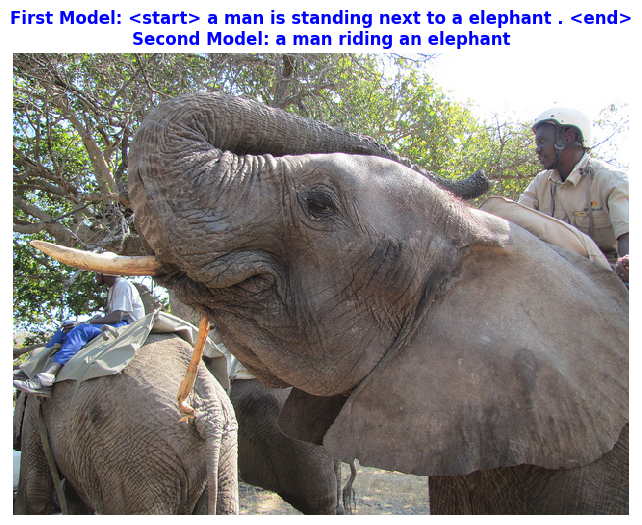

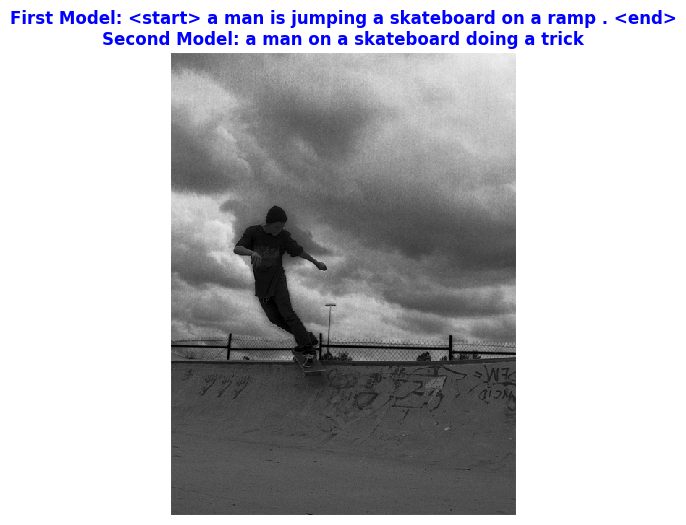

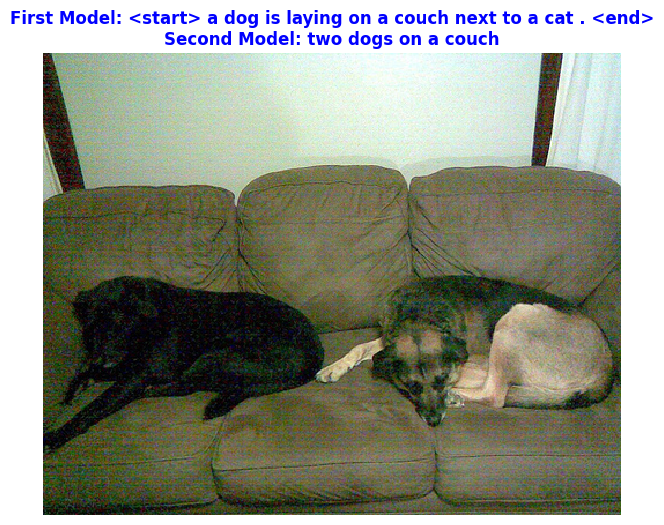

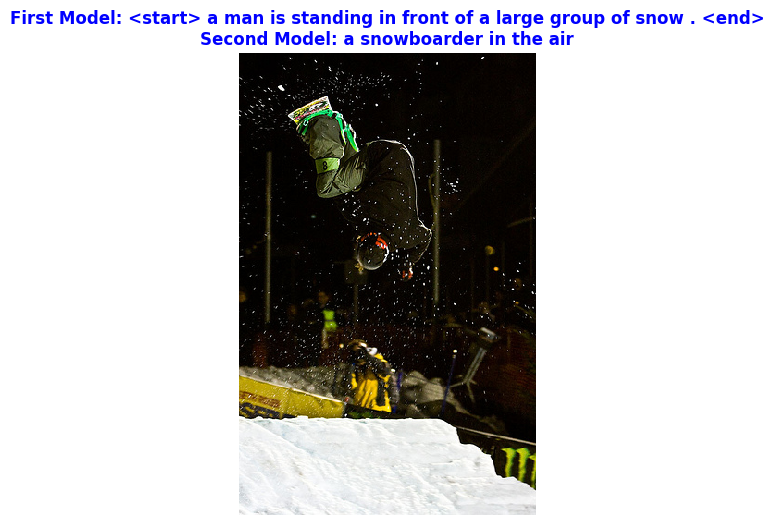

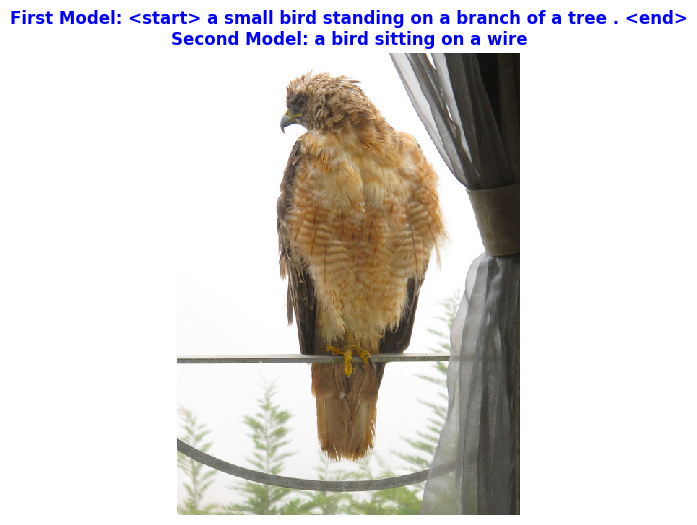

In [15]:
from transformers import CLIPProcessor, CLIPModel
import os

# Define paths to the image directory and COCO annotations file
image_dir = "data/coco/images/val2017"
coco_annotations_path = "data/coco/annotations/captions_val2017.json"

# Total number of images available in the COCO validation set
total_images_available = 5000

# Set the maximum number of images to process
max_images = 5 # max 5000

# Validate that the requested max_images does not exceed the available images
if max_images > total_images_available:
    raise ValueError(f"max_images cannot exceed the total available images ({total_images_available}). "
                     f"Please set max_images to {total_images_available} or less.")

# Load the pre-trained CLIP model and processor for semantic evaluation
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

# Evaluate both models on the selected images
results = evaluate_models(
    image_dir,
    max_images,
    transform,
    device,
    conv,
    lstm,
    vocab,
    coco_annotations_path,
    clip_processor=clip_processor,
    clip_model=clip_model,
    show_images=True  # Set this flag to True to display images during evaluation
)


# Evaluation Results - Column Explanation

| Column Name             | Description |
|-------------------------|-------------|
| **image_id**            | The unique identifier of the image from the COCO dataset. |
| **caption_first_model** | The caption generated by the first model for the given image. |
| **caption_second_model**| The caption generated by the second model for the same image. |
| **reference_captions**  | A list of human-annotated reference captions from the COCO dataset for the image. |
| **rouge_first**         | The ROUGE-L F1 score comparing the first model’s caption with the reference captions. |
| **meteor_first**        | The METEOR score comparing the first model’s caption with the reference captions. |
| **cosine_first**        | The average Cosine Similarity score between the first model’s caption and the reference captions, representing semantic similarity. |
| **clip_loss_first**     | The CLIP Loss computed between the image and the first model’s caption. A lower score indicates better semantic alignment. |
| **rouge_second**        | The ROUGE-L F1 score comparing the second model’s caption with the reference captions. |
| **meteor_second**       | The METEOR score comparing the second model’s caption with the reference captions. |
| **cosine_second**       | The average Cosine Similarity score between the second model’s caption and the reference captions, representing semantic similarity. |
| **clip_loss_second**    | The CLIP Loss computed between the image and the second model’s caption. A lower score indicates better semantic alignment. |

---

### Metrics Explanation

- **ROUGE-L F1 Score**:  
  Measures the overlap of longest common subsequences (LCS) between the generated and reference captions. Higher values indicate better alignment with human-written text.

- **METEOR Score**:  
  Considers precision, recall, stemming, and synonym matches to evaluate the similarity between generated captions and reference captions.

- **Cosine Similarity**:  
  Uses TF-IDF to compute the semantic closeness between the generated captions and reference captions, where **1.0** means identical text and **0.0** means no similarity.

- **CLIP Loss**:  
  Utilizes the CLIP model's multi-modal embeddings to measure the semantic alignment between an image and a generated caption. It is calculated as **1 minus the cosine similarity** between the image and caption embeddings, with lower values indicating better alignment.

---

**Note:**  
The evaluation function was executed on **5000 images** from the COCO dataset to generate comprehensive results. However, for display purposes, the table here shows an example subset of **5 images**.

When calling the evaluation function, be sure to pass the CLIP components as parameters. For example:

```python
results = evaluate_models(
    image_dir, max_images, transform, device, conv, lstm, vocab, coco_annotations_path,
    clip_processor=clip_processor, clip_model=clip_model
)


In [16]:
df = pd.DataFrame(results)

df.style.set_properties(**{'text-align': 'left'}).set_caption("Evaluation Metrics Comparison")


,image_id,caption_first_model,caption_second_model,reference_captions,rouge_first,meteor_first,cosine_first,rouge_second,meteor_second,cosine_second,bleu_first,bleu_second,clip_loss_first,clip_loss_second
0,267191,a man is standing next to a elephant .,a man riding an elephant,"['Two people are riding elephants beside some trees.', 'A man in helmet riding an elephant next to trees.', 'A man that is on the back of a elephant.', ""A man rides on top of an elephant's back."", 'people riding on the backs of some elephants ']",0.000000,0.368317,0.150190,0.153846,0.509474,0.285803,0.052463,0.165817,0.719116,0.731244
1,373315,a man is jumping a skateboard on a ramp .,a man on a skateboard doing a trick,"['A man riding a skateboard up the side of a cement ramp.', 'A skateboarder doing tricks on the rim of a pit', 'Skateboarder grinding his board on the side of a pavement course. ', 'A teen boy is skateboarding on the edge of a cement wall.', 'a boy riding a skateboard on the edge of a wall ']",0.521739,0.401802,0.145677,0.500000,0.521542,0.167306,0.104190,0.062571,0.712060,0.715580
2,236784,a dog is laying on a couch next to a cat .,two dogs on a couch,"['two dogs laying down on a brown couch', 'there are two large dogs sleeping on the couch', 'a couple of dogs are laying on a coach', 'Two black dogs on a couch sleeping peacefully.', 'Two dogs are lying on the brown couch. ']",0.380952,0.391579,0.108056,0.769231,0.628571,0.433000,0.105711,0.417007,0.690639,0.671982
3,456303,a man is standing in front of a large group of snow .,a snowboarder in the air,"['A person on a snowboard who is performing a trick.', 'A man doing a trick upside down on his snow board. ', 'The snowboarder does a flip at a competition.', 'a person jumping a snow board in the air', 'This is a snowboard in the middle of a back flip.']",0.250000,0.276864,0.120858,0.133333,0.436047,0.203030,0.038233,0.165817,0.793325,0.695753
4,270705,a small bird standing on a branch of a tree .,a bird sitting on a wire,"['A large bird perched on top of a stick near a window.', 'A falcon perched on a window looking off in the distance.', 'A large bird is sitting on a metal perch.', 'A hawk is perched on a metal bar.', 'an orange white and black bird and a curtain']",0.416667,0.247934,0.085010,0.444444,0.512644,0.159202,0.049133,0.164498,0.755284,0.750071


# Explanation of the Styled DataFrame Visualization Code

In this Jupyter Notebook cell, we transform our evaluation results (stored in the variable `results`) into a Pandas DataFrame and then apply several styling options to enhance its visual appeal and readability. Below is a detailed explanation of each component of the code:

1. **DataFrame Creation:**
   - `df = pd.DataFrame(results)`:  
     This line converts the list of dictionaries (each containing evaluation metrics for an image captioning model) into a Pandas DataFrame. Each dictionary corresponds to a row, and the keys become the column headers.

2. **Styling the DataFrame:**
   - `df.style`:  
     Returns a Styler object that provides methods to format and style the DataFrame for display in a Jupyter Notebook.
     
   - `.background_gradient(cmap='YlGnBu', subset=[...])`:  
     Applies a background color gradient to a specified subset of columns. In this case, we use the 'YlGnBu' colormap on metric columns such as `'rouge_first'`, `'meteor_first'`, `'cosine_first'`, `'clip_loss_first'`, `'rouge_second'`, `'meteor_second'`, `'cosine_second'`, and `'clip_loss_second'`.  
     **Purpose:**  
     The gradient helps visually compare numerical values across rows, with variations in color intensity highlighting differences in performance.

   - `.format(precision=3)`:  
     Formats all numeric values to display three decimal places.  
     **Purpose:**  
     This ensures consistency and improves readability by avoiding long floating-point numbers.

   - `.set_properties(**{'text-align': 'left'})`:  
     Sets the text alignment to left for all cells in the DataFrame.  
     **Purpose:**  
     Left-aligned text can be easier to read, especially when dealing with a mix of numeric and textual data.

   - `.set_caption("Evaluation Metrics Comparison")`:  
     Adds a caption above the DataFrame table.  
     **Purpose:**  
     The caption provides context about what the table represents, making it easier for the viewer to understand the content at a glance.

   - `.set_table_styles([...])`:  
     Applies custom CSS styles to different parts of the table.  
     **Example Styles Applied:**
     - **Header Cells (`th`):**  
       A light background color (`#f7f7f9`), dark text color (`#333`), and a border (`1px solid #ddd`) are applied.
     - **Data Cells (`td`):**  
       A border (`1px solid #ddd`) is applied to each cell.
     **Purpose:**  
     These styles enhance the overall appearance and ensure that the table is well-structured and easy to read.

3. **Displaying the Styled DataFrame:**
   - Finally, by calling the variable `styled_df`, the styled DataFrame is rendered in the Jupyter Notebook.  
     **Purpose:**  
     The final visual output is a neatly formatted table that highlights key evaluation metrics, making it simpler to compare model performance at a glance.

---

**Overall Impact:**  
This styling approach not only makes your evaluation results more visually appealing but also aids in quickly identifying trends and differences between models through effective use of colors, number formatting, and clear table structure.


In [17]:
import pandas as pd

# Assuming 'results' is your list of dictionaries
df = pd.DataFrame(results)

# Style the DataFrame
styled_df = (
    df.style
      # Apply a background gradient to metric columns for visual comparison
      .background_gradient(
          cmap='YlGnBu', 
          subset=['rouge_first', 'meteor_first', 'cosine_first', 'clip_loss_first',
                  'rouge_second', 'meteor_second', 'cosine_second', 'clip_loss_second']
      )
      # Format numerical columns to 3 decimal places
      .format(precision=3)
      # Align text to the left
      .set_properties(**{'text-align': 'left'})
      # Set a custom caption for the table
      .set_caption("Evaluation Metrics Comparison")
      # Optionally, set custom table styles (e.g., borders)
      .set_table_styles([
          {'selector': 'th', 'props': [('background-color', '#f7f7f9'), ('color', '#333'), ('border', '1px solid #ddd')]},
          {'selector': 'td', 'props': [('border', '1px solid #ddd')]}
      ])
)

styled_df


,image_id,caption_first_model,caption_second_model,reference_captions,rouge_first,meteor_first,cosine_first,rouge_second,meteor_second,cosine_second,bleu_first,bleu_second,clip_loss_first,clip_loss_second
0,267191,a man is standing next to a elephant .,a man riding an elephant,"['Two people are riding elephants beside some trees.', 'A man in helmet riding an elephant next to trees.', 'A man that is on the back of a elephant.', ""A man rides on top of an elephant's back."", 'people riding on the backs of some elephants ']",0.000,0.368,0.150,0.154,0.509,0.286,0.052,0.166,0.719,0.731
1,373315,a man is jumping a skateboard on a ramp .,a man on a skateboard doing a trick,"['A man riding a skateboard up the side of a cement ramp.', 'A skateboarder doing tricks on the rim of a pit', 'Skateboarder grinding his board on the side of a pavement course. ', 'A teen boy is skateboarding on the edge of a cement wall.', 'a boy riding a skateboard on the edge of a wall ']",0.522,0.402,0.146,0.500,0.522,0.167,0.104,0.063,0.712,0.716
2,236784,a dog is laying on a couch next to a cat .,two dogs on a couch,"['two dogs laying down on a brown couch', 'there are two large dogs sleeping on the couch', 'a couple of dogs are laying on a coach', 'Two black dogs on a couch sleeping peacefully.', 'Two dogs are lying on the brown couch. ']",0.381,0.392,0.108,0.769,0.629,0.433,0.106,0.417,0.691,0.672
3,456303,a man is standing in front of a large group of snow .,a snowboarder in the air,"['A person on a snowboard who is performing a trick.', 'A man doing a trick upside down on his snow board. ', 'The snowboarder does a flip at a competition.', 'a person jumping a snow board in the air', 'This is a snowboard in the middle of a back flip.']",0.250,0.277,0.121,0.133,0.436,0.203,0.038,0.166,0.793,0.696
4,270705,a small bird standing on a branch of a tree .,a bird sitting on a wire,"['A large bird perched on top of a stick near a window.', 'A falcon perched on a window looking off in the distance.', 'A large bird is sitting on a metal perch.', 'A hawk is perched on a metal bar.', 'an orange white and black bird and a curtain']",0.417,0.248,0.085,0.444,0.513,0.159,0.049,0.164,0.755,0.750


# Average Evaluation Metrics for Model 1 and Model 2

The table below summarizes the average evaluation metrics for the two image captioning models evaluated over 5000 images from the COCO validation set:

| Metric             | Model 1 Average | Model 2 Average |
|--------------------|-----------------|-----------------|
| ROUGE              | 0.308476        | 0.391182        |
| METEOR             | 0.385384        | 0.432228        |
| Cosine Similarity  | 0.139004        | 0.221101        |
| BLEU               | 0.113935        | 0.212554        |
| CLIP Loss          | 0.734665        | 0.710076        |

---

### Explanation of the Results

- **ROUGE:**  
  A higher ROUGE score indicates a greater overlap between the generated captions and the reference captions. Model 2, with an average score of 0.391182, outperforms Model 1's 0.308476.

- **METEOR:**  
  This metric evaluates both precision and recall and accounts for synonyms and stemming. Model 2 (0.432228) performs better than Model 1 (0.385384), suggesting closer alignment with the ground truth.

- **Cosine Similarity:**  
  Calculated using TF-IDF, this metric measures the semantic similarity between the generated and reference captions. Model 2 shows improved semantic alignment with an average of 0.221101 compared to 0.139004 for Model 1.

- **BLEU:**  
  BLEU assesses the correspondence between the generated captions and the reference captions. With an average score of 0.212554, Model 2 outperforms Model 1 (0.113935), indicating more accurate caption generation.

- **CLIP Loss:**  
  Defined as 1 minus the cosine similarity between image and text embeddings (lower is better), Model 2’s average CLIP Loss (0.710076) is slightly lower than that of Model 1 (0.734665), indicating better image-to-caption alignment.

---

### Conclusion

Overall, the evaluation metrics indicate that **Model 2** consistently outperforms **Model 1** across all measured criteria. This means that Model 2 generates captions that are not only closer to the reference captions in terms of textual overlap but also demonstrate better semantic alignment with the image content.


In [49]:
# Compute average metrics for Model 1
avg_rouge_first = df["rouge_first"].mean()
avg_meteor_first = df["meteor_first"].mean()
avg_cosine_first = df["cosine_first"].mean()
avg_bleu_first = df["bleu_first"].mean()
avg_clip_loss_first = df["clip_loss_first"].mean()

# Compute average metrics for Model 2
avg_rouge_second = df["rouge_second"].mean()
avg_meteor_second = df["meteor_second"].mean()
avg_cosine_second = df["cosine_second"].mean()
avg_bleu_second = df["bleu_second"].mean()
avg_clip_loss_second = df["clip_loss_second"].mean()

# Create a new DataFrame for the averages
avg_data = {
    "Metric": ["ROUGE", "METEOR", "Cosine Similarity", "BLEU", "CLIP Loss"],
    "Model 1 Average": [avg_rouge_first, avg_meteor_first, avg_cosine_first, avg_bleu_first, avg_clip_loss_first],
    "Model 2 Average": [avg_rouge_second, avg_meteor_second, avg_cosine_second, avg_bleu_second, avg_clip_loss_second]
}

avg_df = pd.DataFrame(avg_data)

# Style the table
avg_df_styled = avg_df.style.set_properties(**{'text-align': 'left'}).set_caption("Average Evaluation Metrics for Model 1 and Model 2")
avg_df_styled


,Metric,Model 1 Average,Model 2 Average
0,ROUGE,0.308476,0.391182
1,METEOR,0.385384,0.432228
2,Cosine Similarity,0.139004,0.221101
3,BLEU,0.113935,0.212554
4,CLIP Loss,0.734665,0.710076


In [29]:
#If you want to save the file in a specific folder, you can include an absolute or relative path in the filename. For example:
#path = '/path/to/your/folder/evaluation_metrics_styled.xlsx'
#df.to_excel(path, engine="openpyxl", index=False)
